##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### This notebook is created by [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).

#### **Social links:**
* [LinkedIn](https://linkedin.com/in/tiwari-nitin)
* [GitHub](https://github.com/NSTiwari)
* [Twitter](https://x.com/NSTiwari21)

# Referring Expression Segmentation in images

This notebook guides you to perform referring expression segmentation on images using [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) and draw the inferences using OpenCV and PIL.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/Referring_expression_segmentation_in_images_using_PaliGemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Hugging Face by completing the following steps:

1. Log in to [Hugging Face](https://huggingface.co), or create a new Hugging Face account if you don't already have one.
2. Go to the [PaliGemma model card](https://huggingface.co/google/paligemma-3b-mix-224) to get access to the model.
3. Complete the consent form and accept the terms and conditions.

To generate a Hugging Face token, open your [**Settings** page in Hugging Face](https://huggingface.co/settings), choose **Access Tokens** option in the left pane and click **New token**. In the next window that appears, give a name to your token and choose the type as **Write** to get the write access.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Hugging Face token. Store your Hugging Face token under the name `HF_TOKEN`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Step 1: Install libraries

In [ ]:
!pip install bitsandbytes transformers accelerate peft -q
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"
!pip install -U "huggingface_hub[cli]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.3
    Uninstalling huggingface-hub-0.23.3:
      Successfully uninstalled huggingface-hub-0.23.3


### Step 2: Import libraries

In [ ]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
import sys
from PIL import Image, ImageDraw, ImageFont

### Step 3: Fetch the `big_vision` repository

In [ ]:
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to Python import path.
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

### Step 4: Set environment variables for Hugging Face token

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

### Step 5: Load pre-trained PaliGemma model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

### Step 6: Configure the input image and text prompt

In [ ]:
input_img = "input_image.jpg" # @param {type:"string"}
input_image = Image.open(input_img)
width, height = input_image.size

prompt = "segment person, car" # @param {type: "string"}
prompt = prompt.replace(',', '\n')

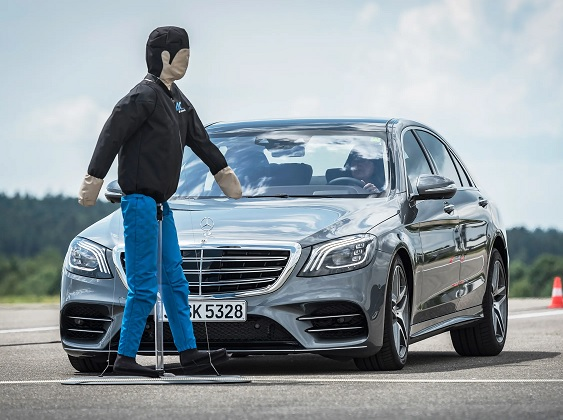

In [ ]:
input_image

### Step 7: Pass the input image and text prompt to PaliGemma

In [ ]:
inputs = processor(text=prompt, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
model.to(device)
inputs = inputs.to(dtype=model.dtype)

In [ ]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

paligemma_response = processor.decode(output[0], skip_special_tokens=True)[len(prompt):].lstrip("\n")
detections = paligemma_response.split(" ; ")

### Step 8: Parse the PaliGemma output

In [ ]:
import big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')

def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])

  coordinates = boxes[0]
  mask = np.array(reconstruct_masks(np.array(segs)))

  return coordinates, mask

### Step 9: Function to draw segmentation mask

In [ ]:
def show_segmentation_output(image, segment_masks, image_size, coordinates_list, labels):

  height, width = image_size
  label_colors = {}
  masked_image = Image.fromarray(np.uint8(image.copy()))

  for i, segment_mask in enumerate(segment_masks):
    coordinates = coordinates_list[i]
    label = labels[i]

    if label not in label_colors:
      label_colors[label] = (np.random.randint(256), np.random.randint(256), np.random.randint(256), 128)

    y1, x1, y2, x2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

    # Get mask width and height.
    w = x2 - x1
    h = y2 - y1

    # Scale the mask
    x_scale = w / 64
    y_scale = h / 64

    # Create coordinate grids for the new image.
    x_coords = np.arange(w)
    y_coords = np.arange(h)
    x_coords = (x_coords / x_scale).astype(int)
    y_coords = (y_coords / y_scale).astype(int)

    # Resize segment mask based on scaling factors.
    resized_segmend_mask = segment_mask[y_coords[:, np.newaxis], x_coords]

    resized_segmend_mask = np.squeeze(resized_segmend_mask)

    pil_image = Image.fromarray(np.uint8(image))

    mask = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    # Draw the mask on the image.
    for y in range(h):
      for x in range(w):
        if resized_segmend_mask[y, x] > 0:
          draw.point((x, y), fill=label_colors[label])


    masked_image.paste(mask, (x1, y1), mask)

  blended_np = np.array(masked_image.convert('RGB'))

  # Overlay the legend on the image.
  legend_y = int(height * 0.03)
  legend_box_width = int(width * 0.05)  # Add padding for text
  legend_box_height = int(height * 0.04)
  for idx, (label, color) in enumerate(label_colors.items()):
    legend_entry_x1 = int(width * 0.84)
    legend_entry_y1 = legend_y
    legend_entry_x2 = legend_entry_x1 + legend_box_width
    legend_entry_y2 = legend_y + legend_box_height
    cv2.rectangle(blended_np, (legend_entry_x1, legend_entry_y1), (legend_entry_x2, legend_entry_y2), color[:3], -1)

    text = label
    text_x = int(width * 0.90)  # Adjust for padding
    text_y = legend_y + (legend_box_height // 2) + 5  # Center vertically in the box

    cv2.putText(blended_np, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    legend_y += legend_box_height + max(height // 200, 5)

  masked_output = Image.fromarray(blended_np.astype('uint8'), 'RGB')

  return masked_output

In [ ]:
segment_masks = []
coordinates_list = []
labels = []

for detection in detections:
  detection = detection.split(" ")
  locations, segmentations, label = detection[0], detection[1], detection[2]
  paligemma_output = locations + segmentations
  bbox, seg_output = parse_segments(paligemma_output)
  segment_masks.append(seg_output[0])
  coordinates_list.append(bbox)
  labels.append(label)

masked_output = show_segmentation_output(input_image, segment_masks, (height, width), coordinates_list, labels)

### Step 10: Display the final output

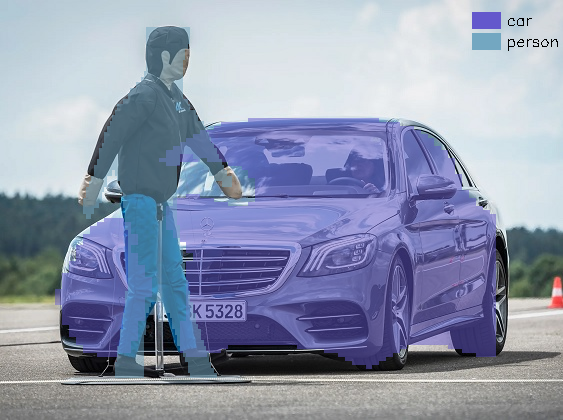

In [ ]:
masked_output